We took two particles down to ~$10^{-6}$ mbar and see how long the parametric feedback could keep them in the trap

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scisig
import scipy.io as sio
import scipy.optimize as opt

In [2]:
def load_data(filepath, channels):
    data = sio.loadmat(filepath)
    tts = np.zeros((len(channels), data['Length'][0][0]))
    for n, i in enumerate(channels):
        tt = np.transpose(data[i])[0]
        tts[n] = tt
    return tts, data['Tinterval'][0][0]

def make_PSDs(filepath, extensions, channels):
    PSDA = []
    PSDB = []
    for extension in extensions:
        tts, Tinterval = load_data(filepath+extension, channels)
        PSD0 = scisig.welch(tts[0], fs = int(1/Tinterval), nperseg = int(0.01/Tinterval))
        PSD1 = scisig.welch(tts[1], fs = int(1/Tinterval), nperseg = int(0.01/Tinterval))
        PSDA.append(PSD0)
        PSDB.append(PSD1)
    PSDA = np.array(PSDA)
    PSDB = np.array(PSDB)
    return PSDA, PSDB

def calc_psd(tt, xx, t_interval=None):
    if t_interval is not None:
        fs = int(np.ceil(1 / t_interval))
    else:
        fs = int(np.ceil(1 / (tt[1] - tt[0])))
    nperseg = fs / 10
    
    return scisig.welch(xx, fs=fs, nperseg=nperseg)

## 20230814
Particle was kepted at ~$10^{-6}$ mbar for a few hours. We think it fell out because the detection drifted away and the PLL no longer locks to the phase

In [4]:
filepath = 'D:\\Experiment\\Cooling\\230814\\Pump Down\\tt ('
extensions = ['16).mat']
channels = ['A', 'B']

tt = []
for extension in extensions:
        tts, Tinterval = load_data(filepath+extension, channels)
        tt.append(tts)
        
PSDA, PSDB = make_PSDs(filepath, extensions, channels)

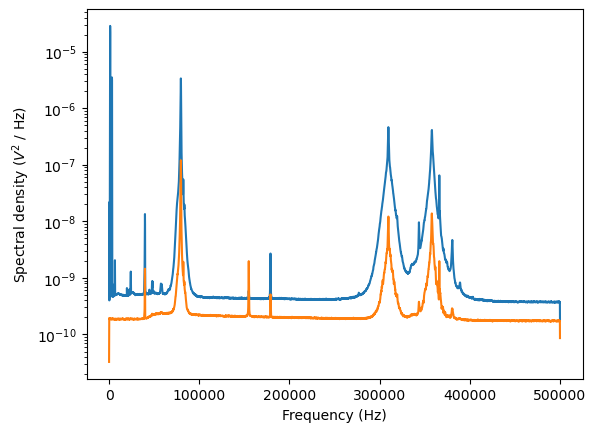

In [5]:
plt.plot(PSDA[0][0], PSDA[0][1])
plt.plot(PSDB[0][0], PSDB[0][1])

plt.xlabel('Frequency (Hz)')
plt.ylabel('Spectral density ($V^2$ / Hz)')
plt.yscale('log')

Still looks OK at this point, altough the y mode is not cooled very well

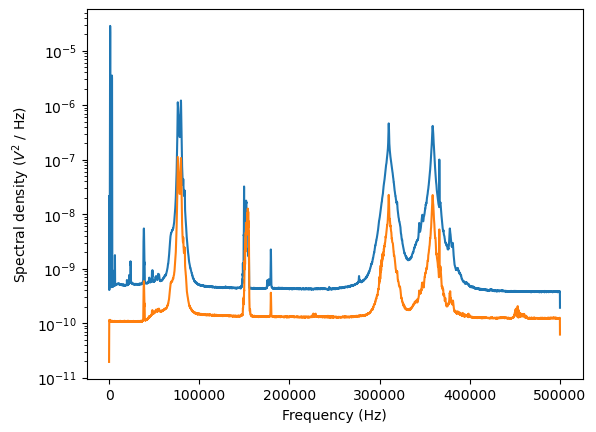

In [7]:
filepath = 'D:\\Experiment\\Cooling\\230814\\Pump Down\\tt ('
channels = ['A', 'B']

for i in range(66, 67):
    extensions = [f'{int(i)}).mat']
    PSDA, PSDB = make_PSDs(filepath, extensions, channels)

    plt.plot(PSDA[0][0], PSDA[0][1])
    plt.plot(PSDB[0][0], PSDB[0][1])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spectral density ($V^2$ / Hz)')
    plt.yscale('log')

Then we completely lost the x detection - the channel is saturated for some reason

69


C:\Users\microspheres\anaconda3\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\microspheres\anaconda3\lib\site-packages\scipy\signal\_signaltools.py:3530: RuntimeWarning: invalid value encountered in subtract
  ret = data - np.mean(data, axis, keepdims=True)
C:\Users\microspheres\anaconda3\lib\site-packages\scipy\signal\_spectral_py.py:1962: RuntimeWarning: invalid value encountered in multiply
  result = win * result


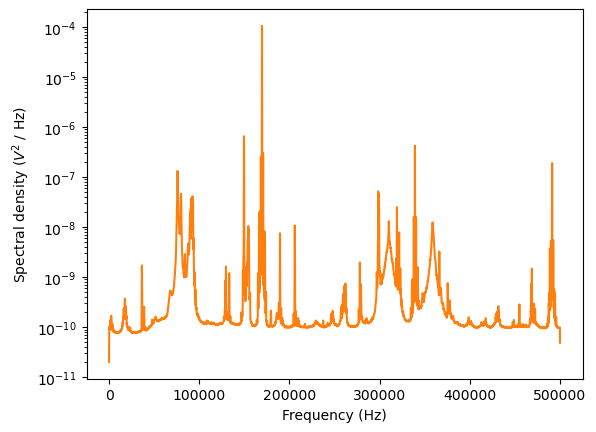

In [8]:
for i in range(69, 70):
    print(i)
    extensions = [f'{int(i)}).mat']
    PSDA, PSDB = make_PSDs(filepath, extensions, channels)

    plt.plot(PSDA[0][0], PSDA[0][1])
    plt.plot(PSDB[0][0], PSDB[0][1])
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spectral density ($V^2$ / Hz)')
    plt.yscale('log')

Text(0, 0.5, 'Signal (V)')

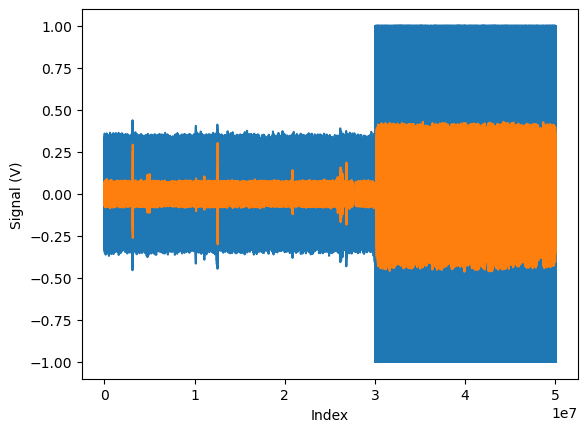

In [11]:
filepath = 'D:\\Experiment\\Cooling\\230814\\Pump Down\\tt ('
channels = ['A', 'B']
extension = '69).mat'

tts, Tinterval = load_data(filepath + extension, channels)

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

plt.plot(tts[0])
plt.plot(tts[1])
plt.xlabel('Index')
plt.ylabel('Signal (V)')

Take a closer look...it seems like the y detection was lost and the PLL started to parametrically drive the particle.

Text(0, 0.5, 'Signal (V)')

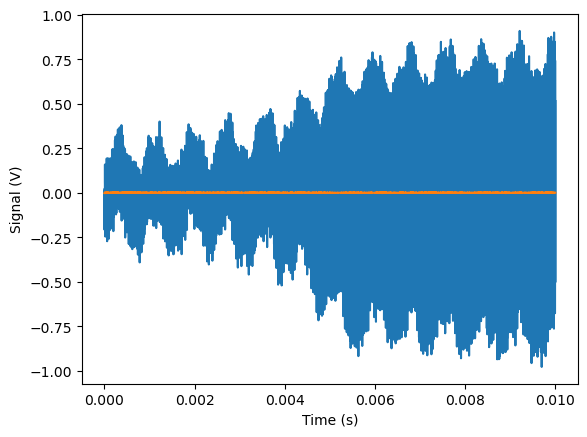

In [46]:
idx = int(3.001e7)
length = 10000

plt.plot(Tinterval * np.arange(length), tts[0][idx:idx+length])
plt.plot(Tinterval * np.arange(length), tts[1][idx:idx+length])

plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')

Text(0, 0.5, 'Signal (V)')

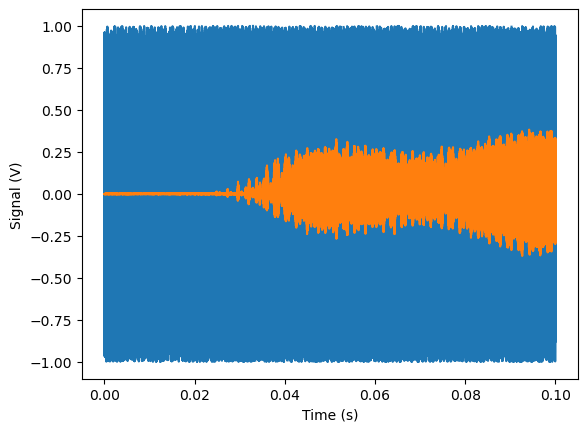

In [45]:
idx = int(3.01e7)
length = 100000

plt.plot(Tinterval * np.arange(length), tts[0][idx:idx+length])
plt.plot(Tinterval * np.arange(length), tts[1][idx:idx+length])

plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')


Also worth noticing that the detection seems to be unstable at times (why aren't we seeing the y-motion?)

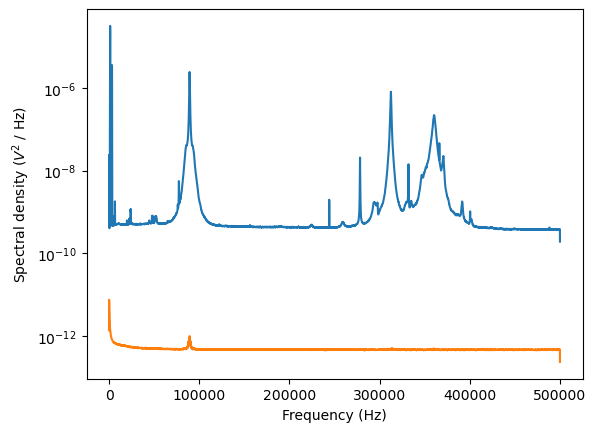

In [12]:
filepath = 'D:\\Experiment\\Cooling\\230814\\Pump Down\\tt ('
channels = ['A', 'B']

for i in range(88, 89):
    extensions = [f'{int(i)}).mat']
    PSDA, PSDB = make_PSDs(filepath, extensions, channels)

    plt.plot(PSDA[0][0], PSDA[0][1])
    plt.plot(PSDB[0][0], PSDB[0][1])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spectral density ($V^2$ / Hz)')
    plt.yscale('log')


## 20230815
Try with a second particle, with feedback signal recorded

In [31]:
def calc_psd_abh(tts, delta_t):
    return calc_psd(None, tts[0], delta_t), calc_psd(None, tts[1], delta_t), calc_psd(None, tts[2], delta_t)
    
def plot_psd_abh(psd_a, psd_b, psd_h):
    plt.plot(psd_a[0], psd_a[1], label='x detection')
    plt.plot(psd_b[0], psd_b[1], label='y detection')
    plt.plot(psd_h[0], psd_h[1], label='feedback')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Spectral density ($V^2$/Hz)')
    plt.legend(frameon=False)
    plt.yscale('log')

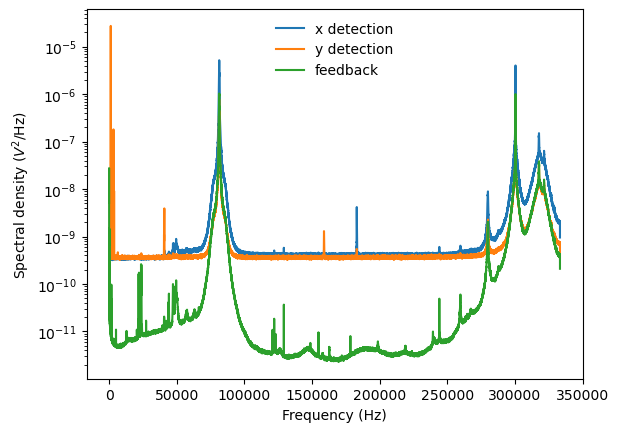

In [51]:
idx = 100
filepath = f'D:\\Experiment\\Cooling\\230815\\Pump Down\\tt ({int(idx)}).mat'
channels = ['A', 'B', 'H']

tts, delta_t = load_data(filepath, channels)
psd_a, psd_b, psd_h = calc_psd_abh(tts, delta_t)
plot_psd_abh(psd_a, psd_b, psd_h)

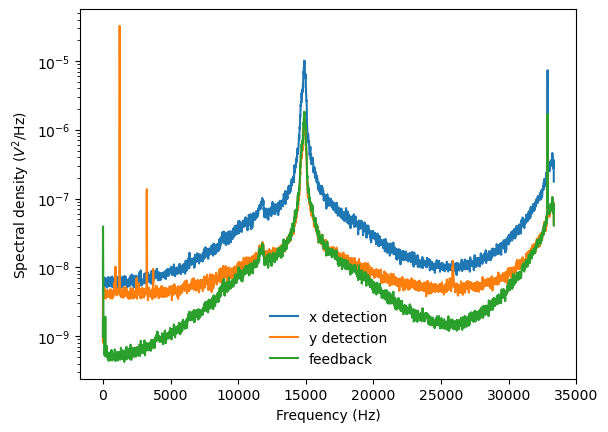

In [54]:
idx = 106
filepath = f'D:\\Experiment\\Cooling\\230815\\Pump Down\\tt ({int(idx)}).mat'
channels = ['A', 'B', 'H']

tts, delta_t = load_data(filepath, channels)
psd_a, psd_b, psd_h = calc_psd_abh(tts, delta_t)
plot_psd_abh(psd_a, psd_b, psd_h)

The x detection got saturated at some point

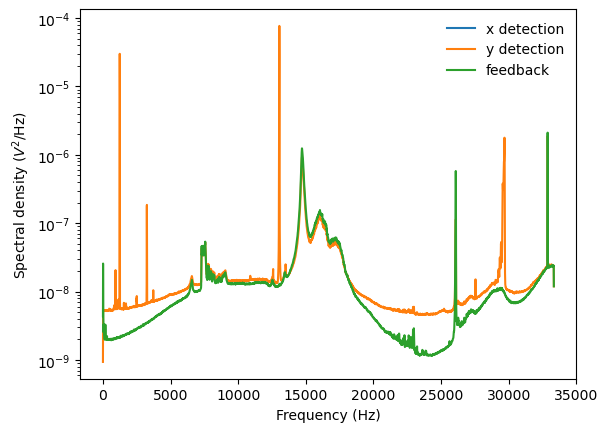

In [41]:
idx = 121
filepath = f'D:\\Experiment\\Cooling\\230815\\Pump Down\\tt ({int(idx)}).mat'
channels = ['A', 'B', 'H']

tts, delta_t = load_data(filepath, channels)
psd_a, psd_b, psd_h = calc_psd_abh(tts, delta_t)
plot_psd_abh(psd_a, psd_b, psd_h)

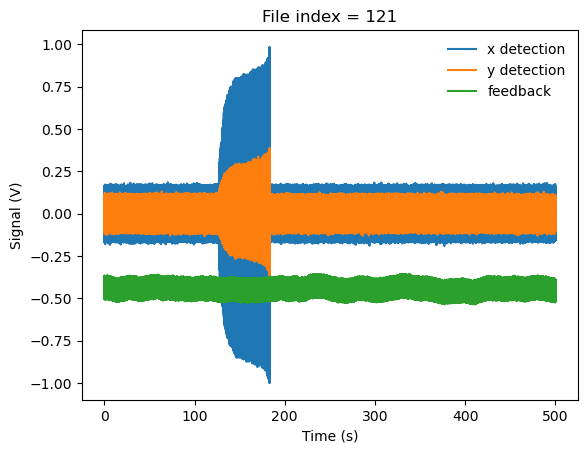

In [3]:
idx = 121
filepath = f'D:\\Experiment\\Cooling\\230815\\Pump Down\\tt ({int(idx)}).mat'
channels = ['A', 'B', 'H']

tts, delta_t = load_data(filepath, channels)

plt.plot(np.arange(0, delta_t*tts.shape[1], delta_t), tts[0], label='x detection')
plt.plot(np.arange(0, delta_t*tts.shape[1], delta_t), tts[1], label='y detection')
plt.plot(np.arange(0, delta_t*tts.shape[1], delta_t), tts[2], label='feedback')

plt.title(f'File index = {idx}')
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.legend(frameon=False)

In [5]:
tts.shape

(3, 33333334)

[]

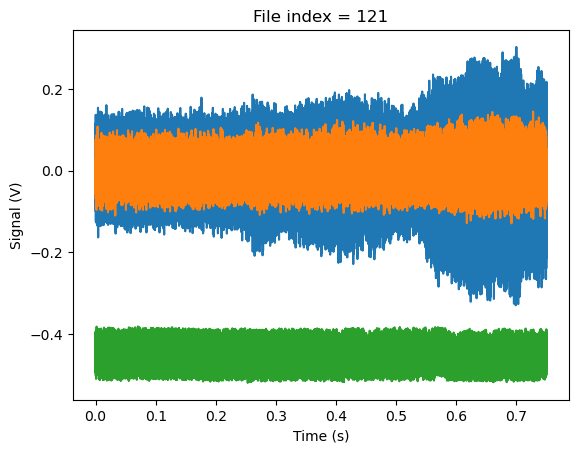

In [26]:
lb = int(0.845e7)
ub = int(lb + 0.5e5)

plt.plot(np.arange(0, delta_t*(ub - lb), delta_t), tts[0][lb:ub], label='x detection')
plt.plot(np.arange(0, delta_t*(ub - lb), delta_t), tts[1][lb:ub], label='y detection')
plt.plot(np.arange(0, delta_t*(ub - lb), delta_t), tts[2][lb:ub], label='feedback')

plt.title(f'File index = {idx}')
plt.xlabel('Time (s)')
plt.ylabel('Signal (V)')
plt.plot()